In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Use the Inspector to explore the database.
inspector = inspect(engine)
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

# Exploratory Climate Analysis

Text(0, 0.5, 'Precipitation (in)')

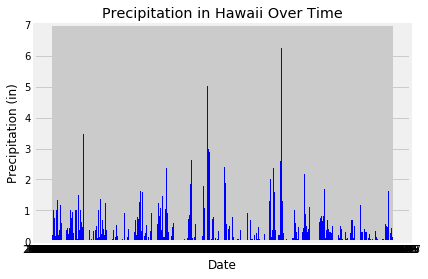

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Note: The Database goes through August, 2017, so I'm taking all of the data September 2016 and later.
engine.execute("""SELECT * FROM measurement where date like '2017%'
               or date like '2016-09%' or date like '2016-1%'""").fetchall()
# Calculate the date 1 year ago from the last data point in the database

#The last date is 2017-08-23, so one year before that is 2016-08-23.

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

last_year_query = engine.execute("""SELECT * FROM measurement where date like '2017%' or date like '2016-09%' or date like '2016-1%'""").fetchall()

# Sort the dataframe by date

m_df = pd.DataFrame(last_year_query, 
                               columns=['Instance Number', 'Station', 'Date', 'Precipitation', 'Temperature'])
# Use Pandas Plotting with Matplotlib to plot the data
measurements_df = m_df.set_index('Date')

plt.bar(m_df['Date'], m_df['Precipitation'], color="b", align="center")
plt.title("Precipitation in Hawaii Over Time")
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
max_prec = measurements_df['Precipitation'].max()
min_prec = measurements_df['Precipitation'].min()
avg_prec = measurements_df['Precipitation'].mean()
med_prec = measurements_df['Precipitation'].median()
print(f'Max Precipitation: {max_prec}')
print(f'Min Precipitation: {min_prec}')
print(f'Average Precipitation: {avg_prec}')
print(f'Median Precipitation: {med_prec}')

Max Precipitation: 6.7
Min Precipitation: 0.0
Average Precipitation: 0.17147865853658564
Median Precipitation: 0.02


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
all_data = engine.execute("""SELECT * FROM measurement""").fetchall()
all_df = pd.DataFrame(all_data, columns=['Instance Number', 'Station', 'Date', 'Precipitation', 'Temperature'])

#Using a Pandas workaround, I used value_counts to find the answer relatively quickly. I know this is maybe not the
#intended solution, but I'll use querying to get answers for the next couple of questions.
len(all_df['Station'].value_counts())

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
all_df['Station'].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: Station, dtype: int64

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
engine.execute("""SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement where station = 'USC00519281'""").fetchall()

[(54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

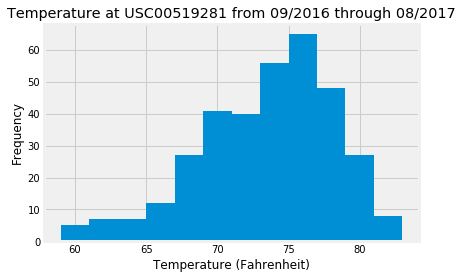

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Another method to do this would be turning all of the observations into a class and filtering by that.

#This queries our data of the Temps at USC00519281 from the past year and stores it into a variable.
most_obvs = engine.execute("""SELECT * FROM measurement where station = 'USC00519281' and (date like '2017%' or date like '2016-09%' or date like '2016-1%')""").fetchall()

#We turn that query into a Pandas DataFrame
most_obvs_df = pd.DataFrame(most_obvs, columns=['Instance Number', 'Station', 'Date', 'Precipitation', 'Temperature'])

plt.hist(most_obvs_df['Temperature'], bins=12)
plt.title("Temperature at USC00519281 from 09/2016 through 08/2017")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#I assume they mean the same dates in 2016?
temps = calc_temps('2016-02-28', '2016-03-05')
temps

[(62.0, 69.88636363636364, 80.0)]

In [20]:
from scipy.stats import sem

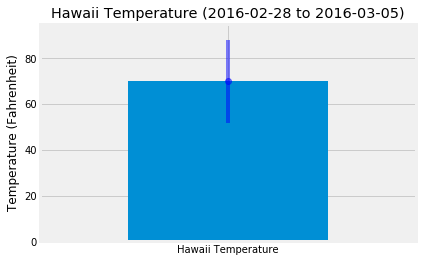

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = temps[0][0]
tavg = temps[0][1]
tmax = temps[0][2]

fig, ax = plt.subplots()

ax.errorbar(0,tavg, yerr=(tmax - tmin), fmt="o", color="b", alpha=0.5)

ax.bar("Hawaii Temperature",tavg)
ax.set_xlim(-.75, .75)
ax.set_ylim(0, 95)

ax.set_title("Hawaii Temperature (2016-02-28 to 2016-03-05)")
ax.set_ylabel("Temperature (Fahrenheit)")

plt.show()


In [46]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#This queries our data of the Temps at all stations from the past year and stores it into a variable.
all_stations = engine.execute("""SELECT * FROM measurement where (date > '2016-02-28' and date < '22016-03-05')""").fetchall()

#We turn that query into a Pandas DataFrame
all_stations_df = pd.DataFrame(most_obvs, columns=['Instance Number', 'Station', 'Date', 'Precipitation', 'Temperature'])

# all_stations_df = all_stations_df.groupby('Station')

print(all_stations_df['Station'].unique())





['USC00519281']


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [51]:
# calculate the daily normals for your trip
normals = []
date_range = ['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']
for date in date_range:
    # push each tuple of calculations into a list called `normals`
    normals.append(daily_normals(date)[0])

normals

[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [56]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, index = date_range, columns=['TMIN', 'TAVG', 'TMAX'])
normals_df

,TMIN,TAVG,TMAX
02-28,65.0,70.655172,80.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


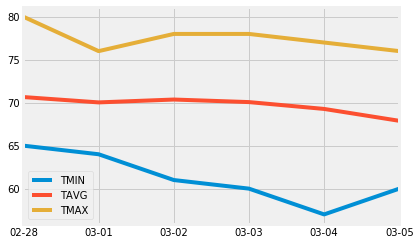

In [59]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.line(stacked=False)